<a href="https://colab.research.google.com/github/jcchou12/ArtAndML_Project2/blob/main/STROTTS_Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STROTSS Style Transfer Notebook

#### [Style Transfer by Relaxed Optimal Transport and Self-Similarity (STROTSS)](https://arxiv.org/abs/1904.12785)

Code from: https://github.com/futscdav/strotss

Notebook by: Peter Schaldenbrand

In [6]:
#@title Download the strotss code from GitHub

import os
if not os.path.exists('/content/strotss'):
    !git clone https://github.com/futscdav/strotss.git
os.chdir('/content/strotss')
from strotss import *

In [7]:
#@title Helper Functions
import torch
import requests
import PIL.Image
from io import BytesIO
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if not torch.cuda.is_available():
    print('YOU ARE NOT USING A GPU.  IT\'S GONNA BE REAAALLLLY SLOW')
    print('Go to the top of the page.  Click Runtime -> Change Runtime Type -> Hardware accelerator')
    print('From the dropdown, select GPU and rerun all this stuff')

def pil_loader_internet(url):
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    return img.convert('RGB')

def show_img(img):
    # Code for displaying at actual resolution from:
    # https://stackoverflow.com/questions/28816046/displaying-different-images-with-actual-size-in-matplotlib-subplot
    dpi = 80
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_style_and_content(style, content):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(content)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Content')
    ax[1].imshow(style)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Style')
    plt.show()

In [16]:
#@title Define STROTSS function
# Redefine the STROTSS function to put some debugging statements in

def strotss(content_pil, style_pil, content_weight=1.0*16.0, device='cuda:0', space='uniform'):
    content_np = pil_to_np(content_pil)
    style_np = pil_to_np(style_pil)
    content_full = np_to_tensor(content_np, space).to(device)
    style_full = np_to_tensor(style_np, space).to(device)

    lr = 2e-3
    extractor = Vgg16_Extractor(space=space).to(device)

    scale_last = max(content_full.shape[2], content_full.shape[3])
    scales = []
    for scale in range(10):
        divisor = 2**scale
        if min(content_pil.width, content_pil.height) // divisor >= 33:
            scales.insert(0, divisor)
    
    clow = -1.0 if space == 'uniform' else -1.7
    chigh = 1.0 if space == 'uniform' else 1.7

    for scale in scales:
        # rescale content to current scale
        content = tensor_resample(content_full, [ content_full.shape[2] // scale, content_full.shape[3] // scale ])
        style = tensor_resample(style_full, [ style_full.shape[2] // scale, style_full.shape[3] // scale ])
        print(f'Optimizing at resolution [{content.shape[2]}, {content.shape[3]}]')

        # upsample or initialize the result
        if scale == scales[0]:
            # first
            result = laplacian(content) + style.mean(2,keepdim=True).mean(3,keepdim=True)
        elif scale == scales[-1]:
            # last 
            result = tensor_resample(result, [content.shape[2], content.shape[3]])
            lr = 1e-3
        else:
            result = tensor_resample(result, [content.shape[2], content.shape[3]]) + laplacian(content)

        # do the optimization on this scale
        result = optimize(result, content, style, scale, content_weight=content_weight, lr=lr, extractor=extractor)

        # Show intermediate result
        result_image = tensor_to_np(torch.clamp(result, clow, chigh)) # 
        # renormalize image
        result_image -= result_image.min()
        result_image /= result_image.max()
        show_img(result_image)

        # next scale lower weight
        content_weight /= 2.0

    result_image = tensor_to_np(tensor_resample(torch.clamp(result, clow, chigh), [content_full.shape[2], content_full.shape[3]])) # 
    # renormalize image
    result_image -= result_image.min()
    result_image /= result_image.max()
    return np_to_pil(result_image * 255.)

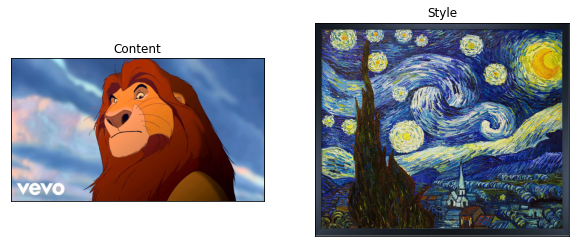

Optimizing at resolution [36, 64]


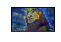

Optimizing at resolution [72, 128]


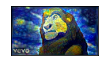

Optimizing at resolution [144, 256]


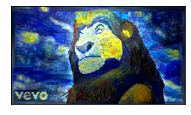

Optimizing at resolution [288, 512]


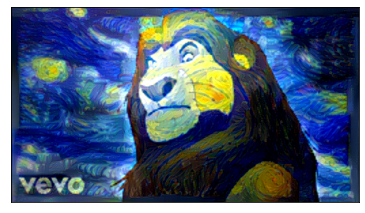

Final Result


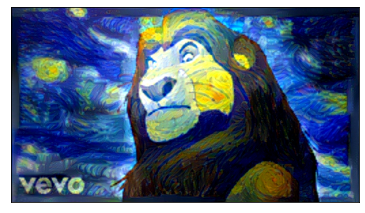

In [17]:
#@title Run STROTSS
#@markdown Put publicly accessible URLs to images for content_url and style_url
content_url = 'https://i.ytimg.com/vi/GibiNy4d4gc/maxresdefault.jpg'  #@param {type:"string"}
style_url = 'https://m.media-amazon.com/images/I/91iS91eizUL._AC_SL1500_.jpg'  #@param {type:"string"}

content_pil = pil_loader_internet(content_url)
style_pil = pil_loader_internet(style_url)
plot_style_and_content(style_pil, content_pil)

max_width = 512  #@param {type:"integer"}

#@markdown How much weight to give to content. 
content_weight = 0.5 #@param {type:"number"}
content_weight *= 16.0 

result = strotss(pil_resize_long_edge_to(content_pil, max_width), 
        pil_resize_long_edge_to(style_pil, max_width), 
        content_weight, device, "vgg")
print('Final Result')
INTERMEDIARY = pil_to_np(result)
show_img(INTERMEDIARY)

DEEPDREAM

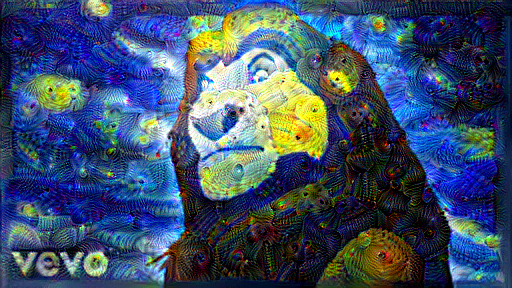

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from google.colab import drive

# drive.mount('/content/grdrive', force_remount=True)
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
# original_img = download(url, max_dim=500)
original_img = INTERMEDIARY
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))


# PREPARE FEATURE EXTRACTION MODEL

#train with InceptionV3
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


# CALCULATE LOSS

def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  return tf.reduce_sum(losses)


# GRADIENT ASCENT

class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img
  
deepdream = DeepDream(dream_model)


# MAIN LOOP

def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)